# Algorithmic Trading Model with ML4T Storage Benchmark Examples
### David Lowe
### June 30, 2022

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This script aims to replicate the examples found in chapter one of the book Machine Learning for Algorithmic Trading by Stefan Jansen. The script seeks to validate further the Python environment and package requirements for running these code examples. The eventual goal is to integrate various example code segments into an end-to-end algorithmic trading system.

This benchmarking exercise used the Google Colab environment as it has the prerequisite libraries and packages already built-in.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Programmatically generated DataFrame with random data

Source and Further Discussion of the Code Examples: https://www.ml4trading.io/chapter/1

# Storage Benchmark

In this notebook, we'll compare the following storage formats:
- CSV: Comma-separated, standard flat text file format.
- HDF5: Hierarchical data format, developed initially at the National Center for Supercomputing Applications. It is a fast and scalable storage format for numerical data, available in pandas using the PyTables library.
- Parquet: Part of the Apache Hadoop ecosystem, a binary, columnar storage format that provides efficient data compression and encoding and has been developed by Cloudera and Twitter. It is available for pandas through the `pyarrow` library, led by Wes McKinney, the original author of pandas.

This notebook compares the performance of the preceding libraries using a test DataFrame that can be configured to contain numerical or text data, or both. For the HDF5 library, we test both the fixed and table formats. The table format allows for queries and can be appended to.

## Usage

To recreate the charts used in the book, you need to run this notebook twice up to section 'Store Result' using different settings for `data_type` and arguments for `generate_test_data` as follows:
1. `data_type='Numeric`: `numerical_cols=1000`, `text_cols=0` (default)
2. `data_type='Mixed`: `numerical_cols=500`, `text_cols=500`

In [1]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


In [2]:
# Retrieve memory configuration information
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 54.8 gigabytes of available RAM



In [3]:
# Retrieve GPU configuration information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Imports & Settings

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string
from datetime import datetime

In [6]:
sns.set_style('whitegrid')

In [7]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [8]:
results = {}

## Generate Test Data

The test `DataFrame` that can be configured to contain numerical or text data, or both. For the HDF5 library, we test both the fixed and table format. 

In [9]:
def generate_test_data(nrows=50000, numerical_cols=1000, text_cols=0, text_length=10):
    s = "".join([random.choice(string.ascii_letters)
                 for _ in range(text_length)])
    data = pd.concat([pd.DataFrame(np.random.random(size=(nrows, numerical_cols))),
                      pd.DataFrame(np.full(shape=(nrows, text_cols), fill_value=s))],
                     axis=1, ignore_index=True)
    data.columns = [str(i) for i in data.columns]
    return data

In [52]:
data_type = 'Mixed'

In [54]:
df = generate_test_data(numerical_cols=500, text_cols=500)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 1000 entries, 0 to 999
dtypes: float64(500), object(500)
memory usage: 381.5+ MB


## Parquet

### Size

In [55]:
parquet_file = Path('test.parquet')

In [56]:
df.to_parquet(parquet_file)
size = parquet_file.stat().st_size

### Read

In [57]:
%%timeit -o
df = pd.read_parquet(parquet_file)

1 loop, best of 5: 862 ms per loop


<TimeitResult : 1 loop, best of 5: 862 ms per loop>

In [58]:
read = _

In [59]:
parquet_file.unlink()

### Write

In [60]:
%%timeit -o
df.to_parquet(parquet_file)
parquet_file.unlink()

1 loop, best of 5: 12.6 s per loop


<TimeitResult : 1 loop, best of 5: 12.6 s per loop>

In [61]:
write = _

### Results

In [62]:
results['Parquet'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

## HDF5

In [63]:
test_store = Path('index.h5')

### Fixed Format

#### Size

In [64]:
with pd.HDFStore(test_store) as store:
    store.put('file', df)
size = test_store.stat().st_size

#### Read

In [65]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.get('file')

1 loop, best of 5: 1min 22s per loop


<TimeitResult : 1 loop, best of 5: 1min 22s per loop>

In [66]:
read = _

In [67]:
test_store.unlink()

#### Write

In [68]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.put('file', df)
test_store.unlink()

1 loop, best of 5: 18.3 s per loop


<TimeitResult : 1 loop, best of 5: 18.3 s per loop>

In [69]:
write = _

#### Results

In [70]:
results['HDF Fixed'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

### Table Format

#### Size

In [71]:
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t')
size = test_store.stat().st_size    

#### Read

In [72]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    df = store.get('file')

1 loop, best of 5: 39.5 s per loop


<TimeitResult : 1 loop, best of 5: 39.5 s per loop>

In [73]:
read = _

In [74]:
test_store.unlink()

#### Write

Note that `write` in table format does not work with text data.

In [75]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t')
test_store.unlink()    

1 loop, best of 5: 1min 5s per loop


<TimeitResult : 1 loop, best of 5: 1min 5s per loop>

In [76]:
write = _

#### Results

In [77]:
results['HDF Table'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

### Table Select

#### Size

In [78]:
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t', data_columns=['company', 'form'])
size = test_store.stat().st_size 

#### Read

In [79]:
company = 'APPLE INC'

In [80]:
%%timeit
with pd.HDFStore(test_store) as store:
    s = store.get('file')

1 loop, best of 5: 44.2 s per loop


In [81]:
read = _

In [82]:
test_store.unlink()

#### Write

In [83]:
%%timeit
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t', data_columns=['company', 'form'])
test_store.unlink() 

1 loop, best of 5: 1min 5s per loop


In [84]:
write = _

#### Results

In [85]:
results['HDF Select'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

## CSV

In [86]:
test_csv = Path('test.csv')

### Size

In [87]:
df.to_csv(test_csv)
test_csv.stat().st_size

757041169

### Read

In [88]:
%%timeit -o
df = pd.read_csv(test_csv)

1 loop, best of 5: 10.9 s per loop


<TimeitResult : 1 loop, best of 5: 10.9 s per loop>

In [89]:
read = _

In [90]:
test_csv.unlink()  

### Write

In [91]:
%%timeit -o
df.to_csv(test_csv)
test_csv.unlink()

1 loop, best of 5: 55.8 s per loop


<TimeitResult : 1 loop, best of 5: 55.8 s per loop>

In [92]:
write = _

### Results

In [93]:
results['CSV'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

## Store Results

In [94]:
pd.DataFrame(results).assign(Data=data_type).to_csv(f'{data_type}.csv')

## Display Results

Please run the notebook twice as described above under `Usage` to create the two `csv` files with results for different test data.

In [106]:
df = (pd.read_csv('Numeric.csv', index_col=0)
      .append(pd.read_csv('Mixed.csv', index_col=0))
      .rename(columns=str.capitalize))
df.index.name='Storage'
df = df.set_index('Data', append=True).unstack()
df.iloc[1] /= 1e6

In [107]:
df

Parquet               Hdf fixed                Hdf table  \
Data          Mixed     Numeric       Mixed      Numeric       Mixed   
Storage                                                                
read       0.910159    2.015634   92.924653   212.813626   44.288362   
size     250.677618  501.369608  526.559612  1051.662696  450.753287   
write     12.829980   29.035646   18.905098    38.493942   70.234465   

                     Hdf select                     Csv              
Data        Numeric       Mixed     Numeric       Mixed     Numeric  
Storage                                                              
read      95.829707   70.234465  149.598850   11.334666   23.370982  
size     900.767225  450.753287  900.767225  450.753287  900.767225  
write    149.598850   70.234465  149.598850   56.752698  117.476676

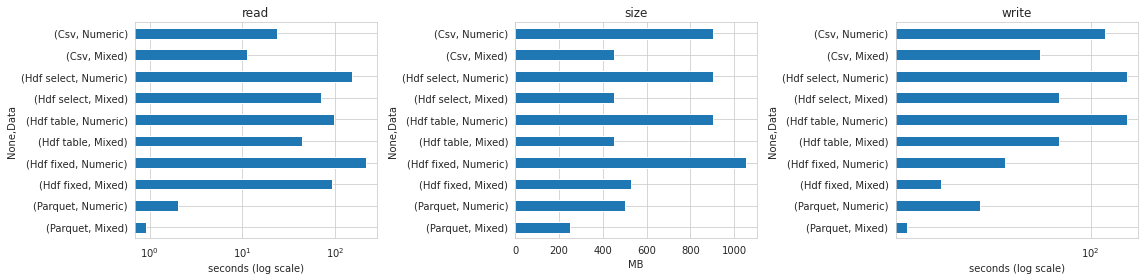

In [123]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
for i, op in enumerate(['read', 'size', 'write']):
    flag= op in ['read', 'write']
    df.iloc[i].plot.barh(title=op, ax=axes[i], logx=flag)
    if flag:
        axes[i].set_xlabel('seconds (log scale)')
    else:
        axes[i].set_xlabel('MB')
fig.tight_layout()
# fig.savefig('storage', dpi=300);

In [124]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 3:36:09.947547
